# EDA for the OTTO – Multi-Objective Recommender System

# Content
1. Intro
2. Setup
3. Import of json and parquet files
4. Shape of Datasets and features
5. Exploring and plotting
6. Cleaning?!

## 1. Intro

Link to Competition: https://www.kaggle.com/competitions/otto-recommender-system/overview

"Goal of the Competition

The goal of this competition is to predict e-commerce clicks, cart additions, and orders. You'll build a multi-objective recommender system based on previous events in a user session.

Your work will help improve the shopping experience for everyone involved. Customers will receive more tailored recommendations while online retailers may increase their sales."


### In this notebook we will explore the given dataset. Partly working with a fraction of the data to make it manageable.
### Given the existing sessions we want to predict the clicks (CTR), add to cart and orders (conversion).


## 2. Setup

In [84]:
### Imports ###

import pandas as pd
import numpy as np
import polars as pl

from pathlib import Path
import os
import random
import json
from datetime import timedelta
from collections import Counter
from heapq import nlargest

from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

## 3. Import of json and parquet files

The otto challenge data is given as a json file. Here: https://www.kaggle.com/competitions/otto-recommender-system/data

For faster processing, the json files can be converted to parquet files with the EDA_0_jason_to_parquet notebook (execution takes longer) 
or downloaded here: https://www.kaggle.com/datasets/radek1/otto-full-optimized-memory-footprint

In [85]:
### importing the json files ###
#train_j = pd.read_json('../data/train.jsonl', lines=True) # takes much time
#test_j = pd.read_json('../data/test.jsonl', lines=True) # not used now

In [86]:
### Counting train dataset without loading ###

with open('../data/train.jsonl', 'r') as f:
    print(f"There are {len(f.readlines()):,} lines in the training data")

# There are 12,899,779 lines in the training data

There are 12,899,779 lines in the training data


In [87]:
### importing only 150.000 lines of the training data ###

sample_size = 150000

chunks = pd.read_json('../data/train.jsonl', lines=True, chunksize = sample_size)

for c in chunks:
    train_j_df = c
    break

In [88]:
### setting index for the ###
train_j_df.set_index('session', drop=True, inplace=True)
train_j_df.head(5)

,events
session,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."


In [89]:
### importing the parquet files ###
train_p = pl.read_parquet('../data/train.parquet')
test_p = pl.read_parquet('../data/test.parquet')

## 4. Shape of datasets and features

- json train: 12,899,779 lines
- parquet train unpacked with every aid in a own line 216,716,096

In [90]:
### shapes of json ###
train_j_df.shape
#test_j.shape



(150000, 1)

In [91]:
### shapes of parquet ###
print(train_p.shape)
print(test_p.shape)

(216716096, 4)
(6928123, 4)


In [92]:
train_p.head()

session,aid,ts,type
i32,i32,i32,u8
0,1517085,1659304800,0
0,1563459,1659304904,0
0,1309446,1659367439,0
0,16246,1659367719,0
0,1781822,1659367871,0


In [93]:
### unique sessions and article ids ###
print(train_p['session'].n_unique())
print(train_p['aid'].n_unique())

12899779
1855603


In [94]:
### click 0, add to cart 1 and order is 2 ###
train_p['type'].unique()

type
u8
0
1
2


In [95]:
### selecting different sessions with specific features ###
q = (
    train_p.lazy()
    .groupby("session")
    .agg(
        [
            (pl.col("type") == 0).sum().alias("click"),
            (pl.col("type") == 1).sum().alias("cart"),
            (pl.col("type") == 2).sum().alias("order"),
        ]
    )
    .sort("click", reverse=False)
    
)

train_p1 = q.collect()

In [96]:
train_p1.head(5)

session,click,cart,order
i32,u32,u32,u32
10485760,2,0,0
2097152,2,1,0
7894232,2,0,0
5302704,2,0,0
7399856,2,0,0


## 5. Exploring and plotting

### 150.000 json dataset train_j_df converted to dataframe

In [97]:
train_j_df = train_j_df.reset_index() #adding index
train_j_df.head #control

<bound method NDFrame.head of         session                                             events
0             0  [{'aid': 1517085, 'ts': 1659304800025, 'type':...
1             1  [{'aid': 424964, 'ts': 1659304800025, 'type': ...
2             2  [{'aid': 763743, 'ts': 1659304800038, 'type': ...
3             3  [{'aid': 1425967, 'ts': 1659304800095, 'type':...
4             4  [{'aid': 613619, 'ts': 1659304800119, 'type': ...
...         ...                                                ...
149995   149995  [{'aid': 443027, 'ts': 1659332465408, 'type': ...
149996   149996  [{'aid': 1849006, 'ts': 1659332465484, 'type':...
149997   149997  [{'aid': 135905, 'ts': 1659332465575, 'type': ...
149998   149998  [{'aid': 288928, 'ts': 1659332465804, 'type': ...
149999   149999  [{'aid': 1752139, 'ts': 1659332465811, 'type':...

[150000 rows x 2 columns]>

In [98]:
### json to df and from 150,000 to 7 million... ###
events_dict = {
    "session": [],
    "aid": [],
    "ts": [],
    "type": [],
}

for _, row in train_j_df.iterrows():
    for event in row["events"]:
        events_dict["session"].append(row["session"])
        events_dict["aid"].append(event["aid"])
        events_dict["ts"].append(event["ts"])
        events_dict["type"].append(event["type"])

train_part = pd.DataFrame(events_dict)
train_part

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
7841822,149998,752186,1659332590213,clicks
7841823,149999,1752139,1659332465811,clicks
7841824,149999,276163,1659332518642,clicks
7841825,149999,1617030,1660131815785,clicks


In [99]:
### changing the time ###
#train_part['ts'] = pd.to_datetime(train_part['ts'], unit='ms')
#display(train_part)

In [100]:
### stats of the dataset ###
n_sessions = train_part["session"].nunique()
n_events = train_part.shape[0]

print(f"Number of sessions: {n_sessions}")
print(f"Number of events: {n_events}")
print(f"Mean number of events in session: {n_events/n_sessions}")

Number of sessions: 150000
Number of events: 7841827
Mean number of events in session: 52.27884666666667


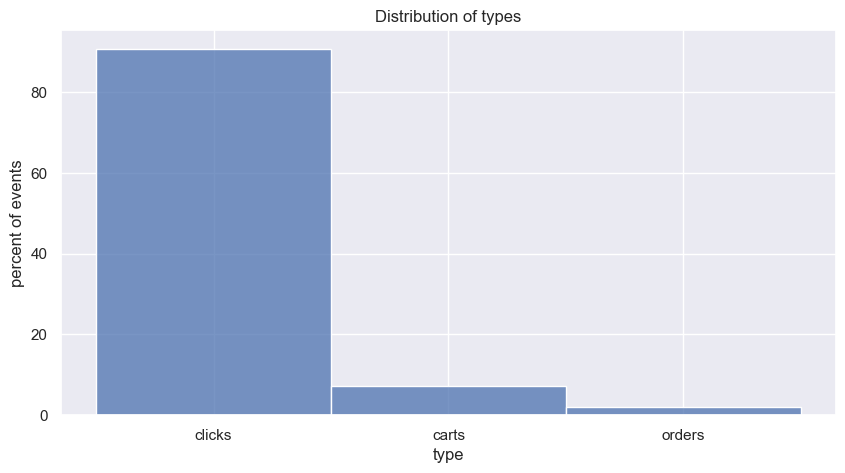

In [101]:
### Distribution of click, cart and order in part of the dataset ###
#sns.color_palette("rocket", as_cmap=True)

plt.figure(figsize=(10, 5))
sns.histplot(train_part['type'], stat='percent', kde=False, bins=100, palette="rocket")
plt.title('Distribution of types')
plt.xlabel('type')
plt.ylabel('percent of events')
plt.show()

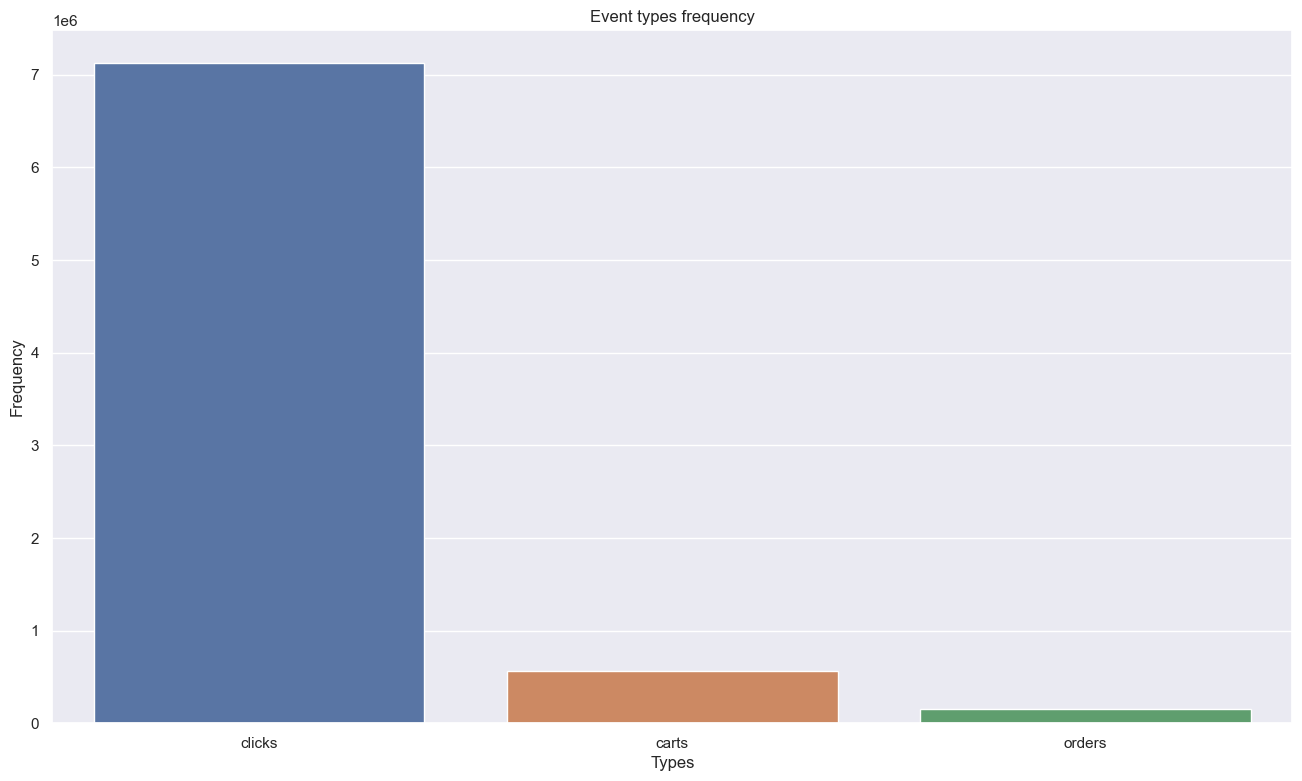

In [102]:
### frequency with colors ###
events_types = train_part.groupby(['type'])['type'].count().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(x=events_types.index, y=events_types.values, ax=ax)
ax.set_title('Event types frequency', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Types', fontsize=12)
plt.show()

### Time of sessions

In [103]:
### calculating seconds ###
def count_seconds(x):
    max_value = int(x.max())
    min_value = int(x.min())
    session_time = timedelta(microseconds=max_value - min_value)
    return session_time.total_seconds() / 60 

In [104]:
train_part

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
7841822,149998,752186,1659332590213,clicks
7841823,149999,1752139,1659332465811,clicks
7841824,149999,276163,1659332518642,clicks
7841825,149999,1617030,1660131815785,clicks


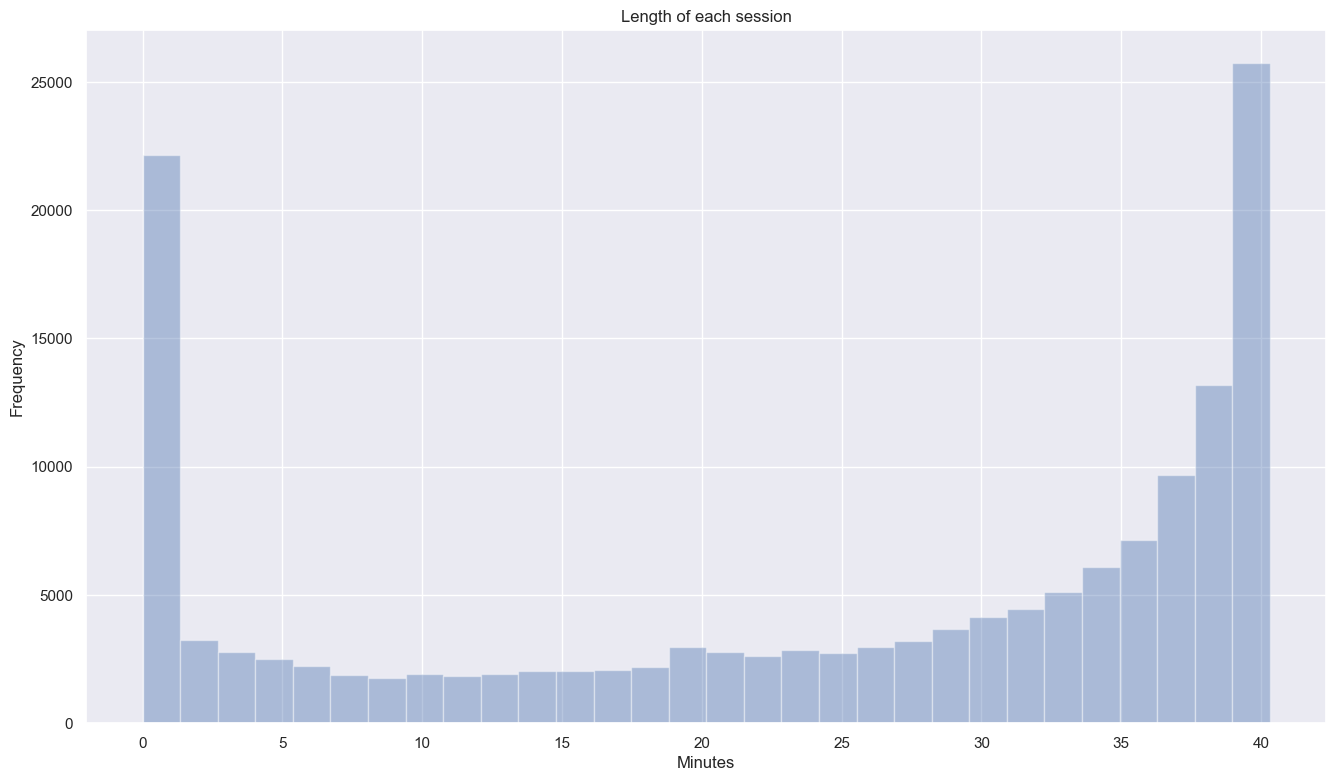

In [105]:
### Duration of session ###
time_counts = train_part.groupby(['session'])['ts'].apply(count_seconds)
fig, ax = plt.subplots(figsize=(16, 9))
sns.distplot(x=time_counts.values, ax=ax, bins=30, kde=False)
ax.set_title('Length of each session', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Minutes', fontsize=12)
plt.show()

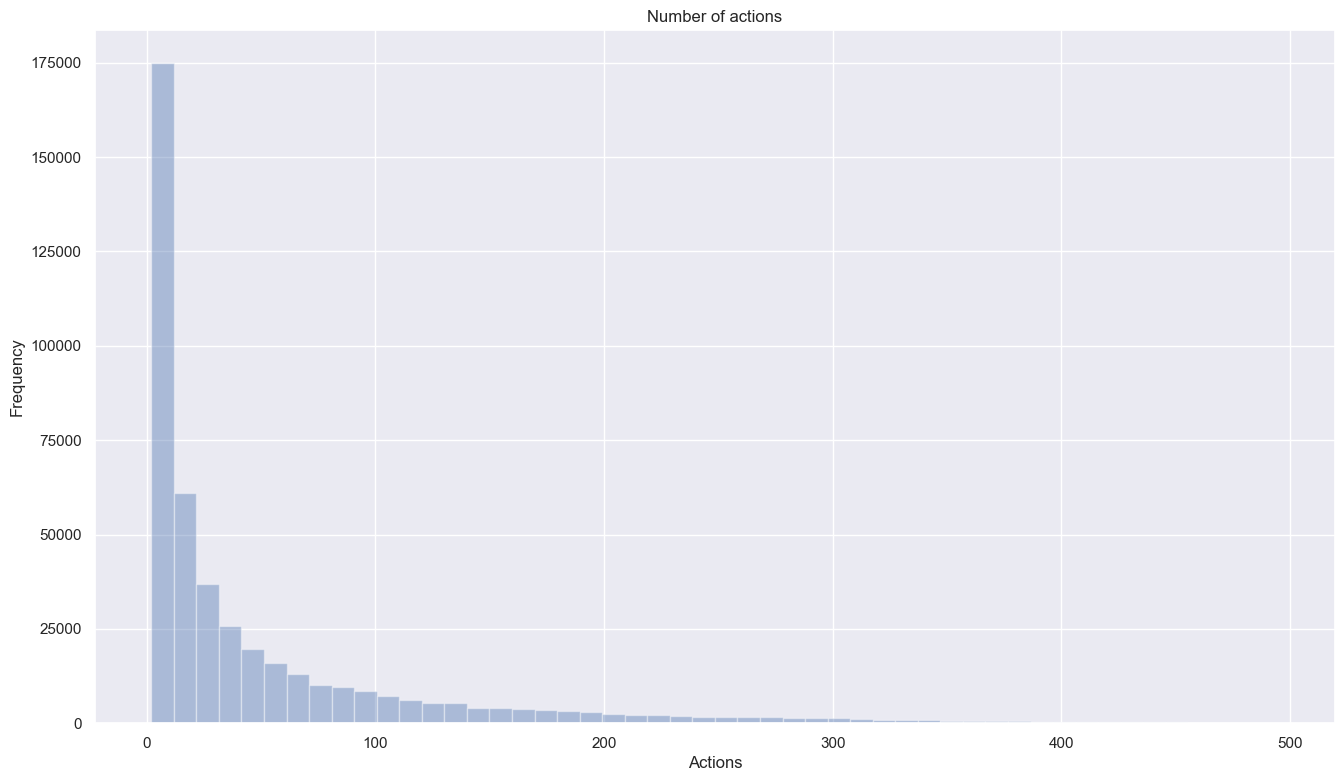

In [106]:
### Number of actions in a session ###
event_types_in_session = train_part.groupby(['session']).count()
fig, ax = plt.subplots(figsize=(16, 9))
sns.distplot(x=event_types_in_session.values, ax=ax, bins=50, kde=False)
ax.set_title('Number of actions', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Actions', fontsize=12)
plt.show()

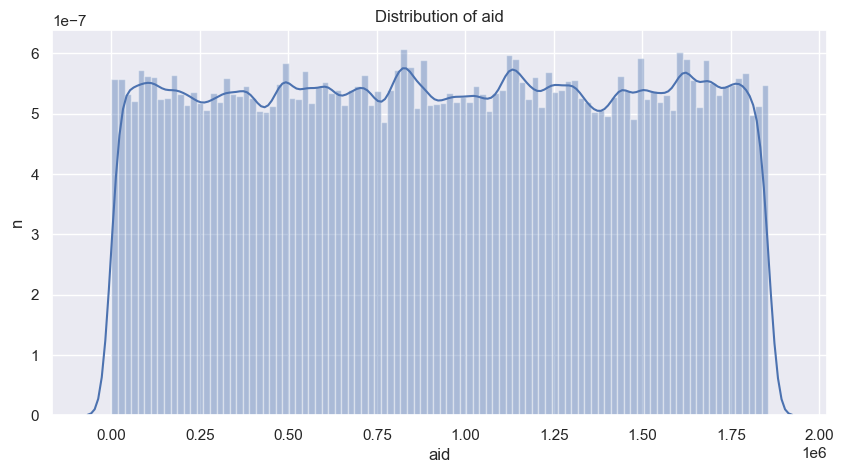

In [107]:
### Articl id ###
plt.figure(figsize=(10, 5))
sns.distplot(train_part['aid'], bins=100)
plt.title('Distribution of aid')
plt.xlabel('aid')
plt.ylabel('n')
plt.show()

### Actions

In [108]:
### Orders after add to cart ###
# Percentage of orders occuring after add to cart events
train_part['order'] = train_part['type'].apply(lambda x: 1 if x == 'orders' else 0)
train_part['add_to_cart'] = train_part['type'].apply(lambda x: 1 if x == 'carts' else 0)
train_part['order_after_cart'] = train_part['order'].shift(-1) + train_part['add_to_cart']
train_part['order_after_cart'] = train_part['order_after_cart'].apply(lambda x: 1 if x == 2 else 0)

In [109]:
perc = train_part['order_after_cart'].value_counts(normalize=True)[1]

print(f'Percentage of orders occuring after add to cart events: {perc:.2%}')

Percentage of orders occuring after add to cart events: 0.61%


In [110]:
### Add to cart after click ###
# Percentage of add_to_cart events occuring after click events
train_part['click'] = train_part['type'].apply(lambda x: 1 if x == 'clicks' else 0)
train_part['cart_after_click'] = train_part['click'].shift(-1) + train_part['add_to_cart']
train_part['cart_after_click'] = train_part['cart_after_click'].apply(lambda x: 1 if x == 2 else 0)

In [111]:
perc = train_part['cart_after_click'].value_counts(normalize=True)[1]

print(f'Percentage of add_to_cart events occuring after click events: {perc:.2%}')

Percentage of add_to_cart events occuring after click events: 5.83%


In [112]:
### click after click ###
# Percentage of click events occuring after click events
train_part['click_after_click'] = train_part['click'].shift(-1) + train_part['click']
train_part['click_after_click'] = train_part['click_after_click'].apply(lambda x: 1 if x == 2 else 0)

In [113]:
perc = train_part['click_after_click'].value_counts(normalize=True)[1]

print(f'Percentage of click events occuring after click events: {perc:.2%}')

Percentage of click events occuring after click events: 83.94%


In [114]:
train_part.head()

,session,aid,ts,type,order,add_to_cart,order_after_cart,click,cart_after_click,click_after_click
0,0,1517085,1659304800025,clicks,0,0,0,1,0,1
1,0,1563459,1659304904511,clicks,0,0,0,1,0,1
2,0,1309446,1659367439426,clicks,0,0,0,1,0,1
3,0,16246,1659367719997,clicks,0,0,0,1,0,1
4,0,1781822,1659367871344,clicks,0,0,0,1,0,1


In [115]:
train_part.info

<bound method DataFrame.info of          session      aid             ts    type  order  add_to_cart  \
0              0  1517085  1659304800025  clicks      0            0   
1              0  1563459  1659304904511  clicks      0            0   
2              0  1309446  1659367439426  clicks      0            0   
3              0    16246  1659367719997  clicks      0            0   
4              0  1781822  1659367871344  clicks      0            0   
...          ...      ...            ...     ...    ...          ...   
7841822   149998   752186  1659332590213  clicks      0            0   
7841823   149999  1752139  1659332465811  clicks      0            0   
7841824   149999   276163  1659332518642  clicks      0            0   
7841825   149999  1617030  1660131815785  clicks      0            0   
7841826   149999   674554  1660132675505  clicks      0            0   

         order_after_cart  click  cart_after_click  click_after_click  
0                       0      

### Data per customer

In [116]:
### not a polar dataframe ###
train_part.columns

Index(['session', 'aid', 'ts', 'type', 'order', 'add_to_cart',
       'order_after_cart', 'click', 'cart_after_click', 'click_after_click'],
      dtype='object')

In [117]:
### changing to polar dataframe ###
train_part = pl.DataFrame(train_part)

In [118]:
### polar select works now ### 
train_part = train_part.select(["session", "aid", "ts", "type"])
print(train_part)

shape: (7841827, 4)
┌─────────┬─────────┬───────────────┬────────┐
│ session ┆ aid     ┆ ts            ┆ type   │
│ ---     ┆ ---     ┆ ---           ┆ ---    │
│ i64     ┆ i64     ┆ i64           ┆ str    │
╞═════════╪═════════╪═══════════════╪════════╡
│ 0       ┆ 1517085 ┆ 1659304800025 ┆ clicks │
│ 0       ┆ 1563459 ┆ 1659304904511 ┆ clicks │
│ 0       ┆ 1309446 ┆ 1659367439426 ┆ clicks │
│ 0       ┆ 16246   ┆ 1659367719997 ┆ clicks │
│ ...     ┆ ...     ┆ ...           ┆ ...    │
│ 149999  ┆ 1752139 ┆ 1659332465811 ┆ clicks │
│ 149999  ┆ 276163  ┆ 1659332518642 ┆ clicks │
│ 149999  ┆ 1617030 ┆ 1660131815785 ┆ clicks │
│ 149999  ┆ 674554  ┆ 1660132675505 ┆ clicks │
└─────────┴─────────┴───────────────┴────────┘


In [119]:
grouped_train = train_part.groupby('session').count()
grouped_train.describe()

describe,session,count
str,f64,f64
"""count""",150000.0,150000.0
"""null_count""",0.0,0.0
"""mean""",74999.5,52.278847
"""std""",43301.414527,76.378569
"""min""",0.0,2.0
"""max""",149999.0,495.0
"""median""",74999.5,19.0


In [120]:
grouped_train.head

<bound method DataFrame.head of shape: (150000, 2)
┌─────────┬───────┐
│ session ┆ count │
│ ---     ┆ ---   │
│ i64     ┆ u32   │
╞═════════╪═══════╡
│ 0       ┆ 276   │
│ 32768   ┆ 13    │
│ 65536   ┆ 5     │
│ 98304   ┆ 29    │
│ ...     ┆ ...   │
│ 141887  ┆ 3     │
│ 10815   ┆ 228   │
│ 43583   ┆ 3     │
│ 109119  ┆ 4     │
└─────────┴───────┘>

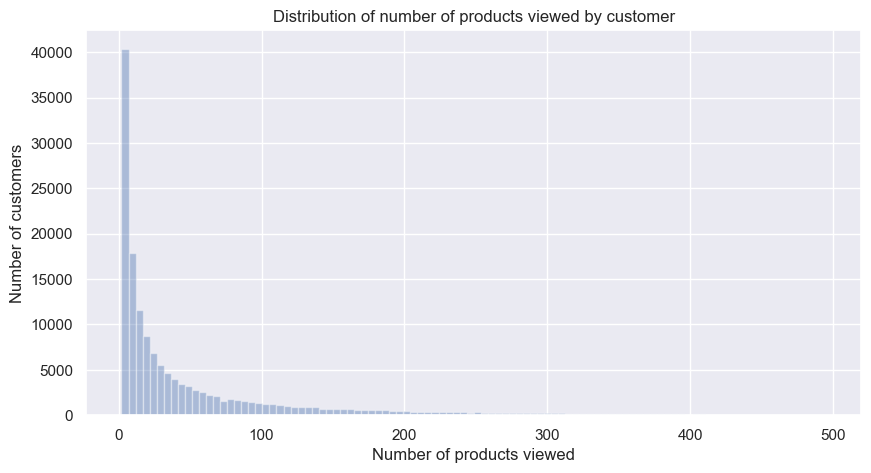

In [121]:
### articles viewed by customer ###
plt.figure(figsize=(10, 5))
sns.distplot(grouped_train['count'], kde=False, bins=100)
plt.title('Distribution of number of products viewed by customer')
plt.xlabel('Number of products viewed')
plt.ylabel('Number of customers')
plt.show()

### need new pandas df

In [130]:
#pandas dataframe needed
### json to df and from 150,000 to 7 million... ###
events_dict = {
    "session": [],
    "aid": [],
    "ts": [],
    "type": [],
}

for _, row in train_j_df.iterrows():
    for event in row["events"]:
        events_dict["session"].append(row["session"])
        events_dict["aid"].append(event["aid"])
        events_dict["ts"].append(event["ts"])
        events_dict["type"].append(event["type"])

train_1 = pd.DataFrame(events_dict)
train_1

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
7841822,149998,752186,1659332590213,clicks
7841823,149999,1752139,1659332465811,clicks
7841824,149999,276163,1659332518642,clicks
7841825,149999,1617030,1660131815785,clicks


In [127]:
### changing to pd dataframe ###
#train_part1 = pd.DataFrame(train_part)#is wrongly transposed

In [133]:
grouped_train = train_1.groupby('session').count()
grouped_train.describe()

,aid,ts,type
count,150000.000000,150000.000000,150000.000000
mean,52.278847,52.278847,52.278847
std,76.378569,76.378569,76.378569
min,2.000000,2.000000,2.000000
25%,6.000000,6.000000,6.000000
50%,19.000000,19.000000,19.000000
75%,64.000000,64.000000,64.000000
max,495.000000,495.000000,495.000000


In [141]:
grouped_train_orders = train_1[train_1['type'] == 'orders'].groupby('session').count().join(grouped_train, lsuffix='_orders', rsuffix='_views')   


In [144]:
display(grouped_train_orders)

,aid_orders,ts_orders,type_orders,type_count
session,,,,
0,4,4,4,276
3,5,5,5,226
4,1,1,1,19
11,2,2,2,93
12,1,1,1,5
...,...,...,...,...
149973,5,5,5,24
149976,1,1,1,15
149990,1,1,1,24


In [143]:
grouped_train_orders = grouped_train_orders.drop(['aid_views', 'ts_views'], axis=1).rename(columns={'type_views': 'type_count'})

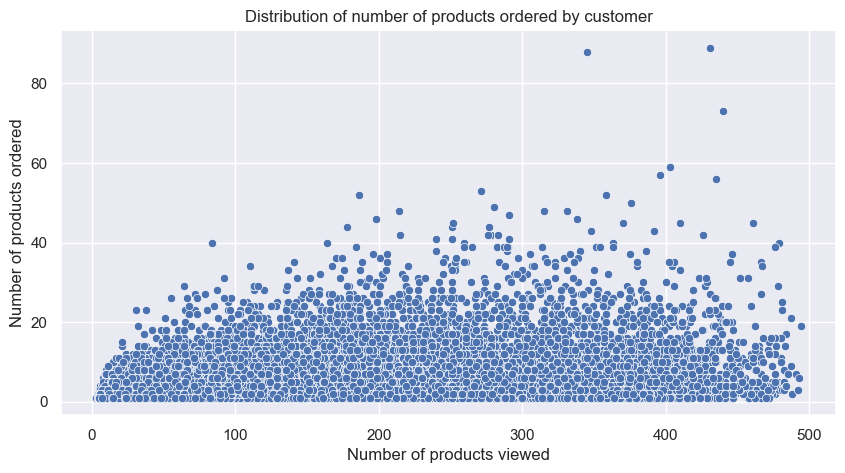

In [145]:
# plot trend between event count and event type orders
plt.figure(figsize=(10, 5))
sns.scatterplot(x=grouped_train_orders['type_count'], y=grouped_train_orders['aid_orders'])
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products viewed')
plt.ylabel('Number of products ordered')
plt.show()

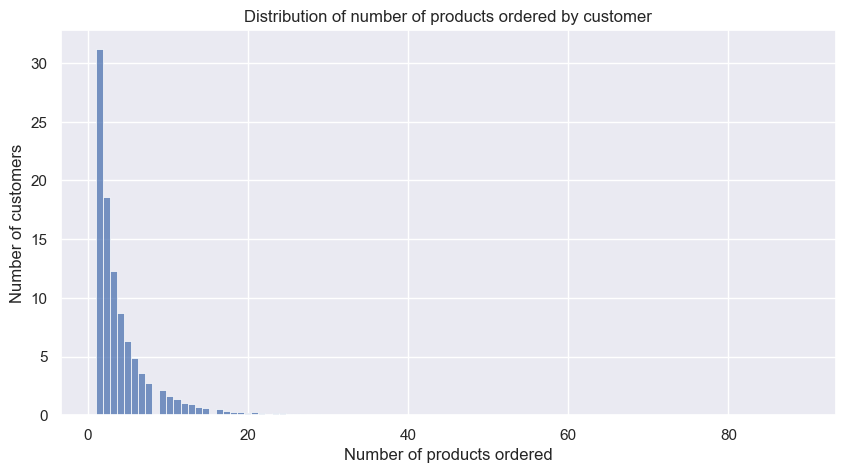

In [146]:
### Distribution of number of products ordered by customers
plt.figure(figsize=(10, 5))
sns.histplot(grouped_train_orders['aid_orders'], stat='percent', kde=False, bins=100)
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products ordered')
plt.ylabel('Number of customers')
plt.show()

In [147]:
grouped_train_clicks = train_1[train_1['type'] == 'clicks'].groupby('session').count().join(grouped_train, lsuffix='_clicks', rsuffix='_views')   


In [151]:
grouped_train_clicks.head()

,aid_clicks,ts_clicks,type_clicks,type_count
session,,,,
0,255,255,255,276
1,24,24,24,32
2,32,32,32,33
3,200,200,200,226
4,15,15,15,19


In [149]:
grouped_train_clicks = grouped_train_clicks.drop(['aid_views', 'ts_views'], axis=1).rename(columns={'type_views': 'type_count'})

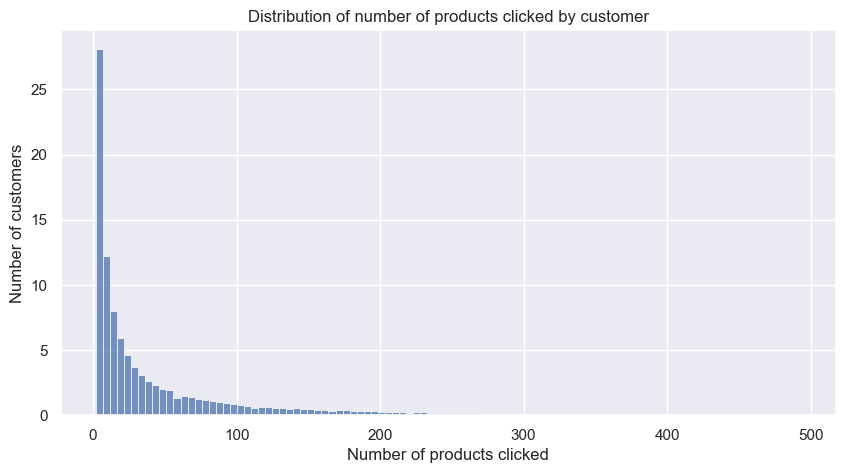

In [152]:
### Distribution of number of products clicked
plt.figure(figsize=(10, 5))
sns.histplot(grouped_train_clicks['aid_clicks'], stat='percent', kde=False, bins=100)
plt.title('Distribution of number of products clicked by customer')
plt.xlabel('Number of products clicked')
plt.ylabel('Number of customers')
plt.show()

In [153]:
grouped_train_carts = train_1[train_1['type'] == 'carts'].groupby('session').count().join(grouped_train, lsuffix='_carts', rsuffix='_views')
grouped_train_orders = train_1[train_1['type'] == 'orders'].groupby('session').count().join(grouped_train, lsuffix='_orders', rsuffix='_views')

In [154]:
grouped_train_carts

,aid_carts,ts_carts,type_carts,aid_views,ts_views,type_views
session,,,,,,
0,17,17,17,276,276,276
1,8,8,8,32,32,32
2,1,1,1,33,33,33
3,21,21,21,226,226,226
4,3,3,3,19,19,19
...,...,...,...,...,...,...
149979,1,1,1,11,11,11
149987,3,3,3,20,20,20
149990,6,6,6,24,24,24


In [155]:
grouped_train_carts = grouped_train_carts.drop(['aid_views', 'ts_views', 'ts_carts', 'type_carts'], axis=1).rename(columns={'type_views': 'type_count'})
grouped_train_corders = grouped_train_orders.drop(['aid_views', 'ts_views', 'ts_orders', 'type_orders'], axis=1).rename(columns={'type_views': 'type_count'})

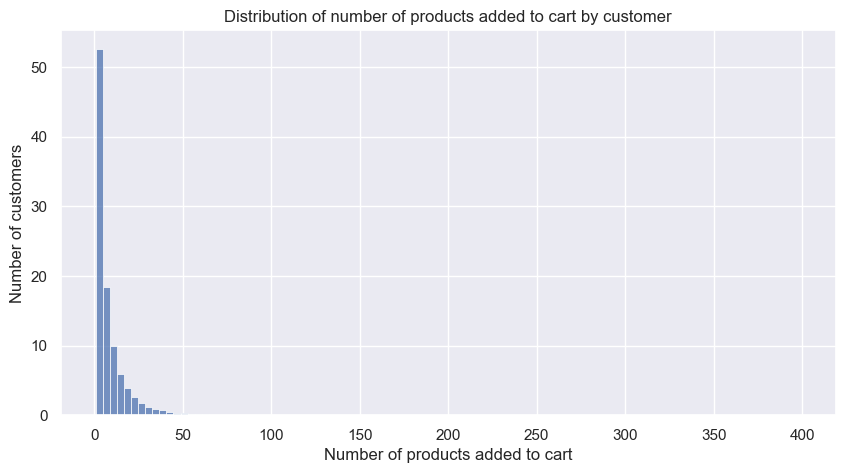

In [156]:
### Distribution of number of products added to cart
plt.figure(figsize=(10, 5))
sns.histplot(grouped_train_carts['aid_carts'], stat='percent', kde=False, bins=100)
plt.title('Distribution of number of products added to cart by customer')
plt.xlabel('Number of products added to cart')
plt.ylabel('Number of customers')
plt.show()

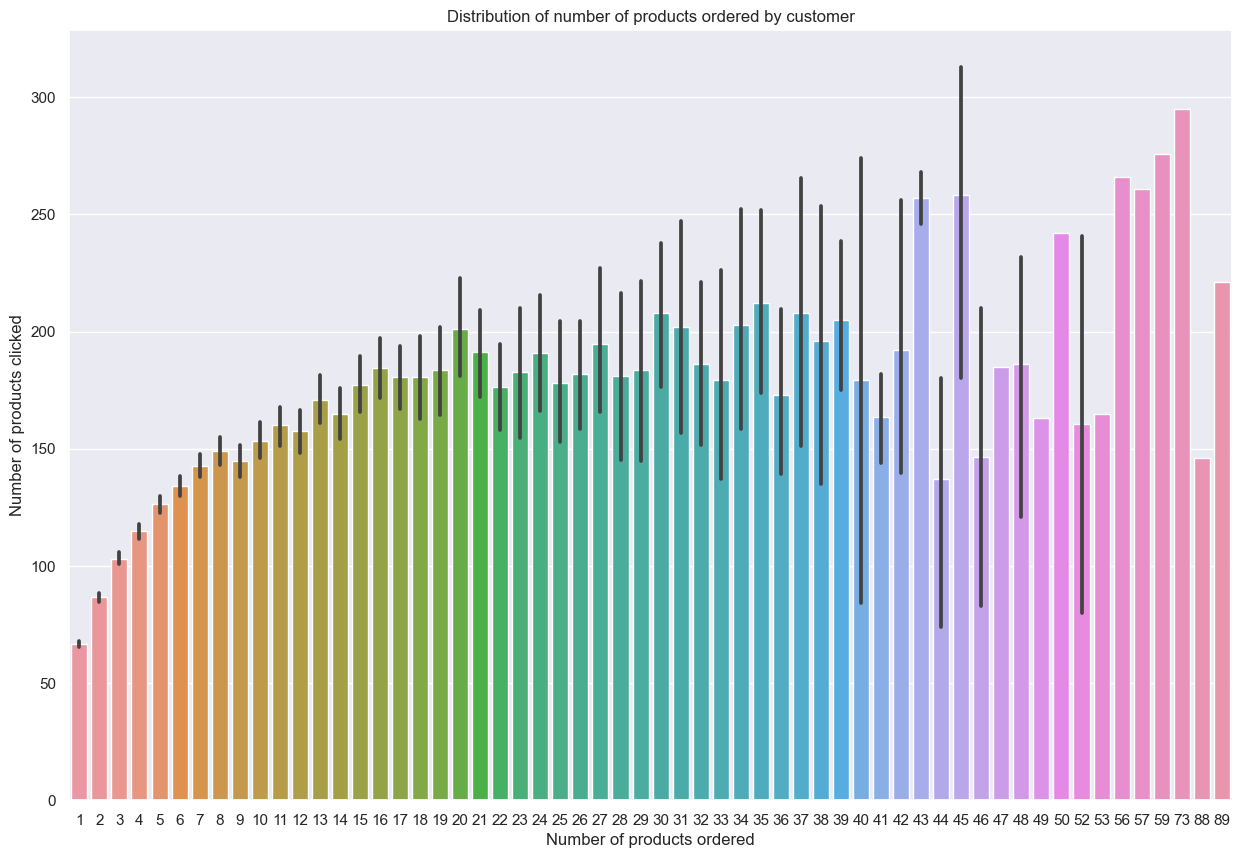

In [157]:
# Number of products ordered vs. number of products clicked
plt.figure(figsize=(15, 10))
sns.barplot(x=grouped_train_orders['aid_orders'], y=grouped_train_clicks['aid_clicks'])
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products ordered')
plt.ylabel('Number of products clicked')
plt.show()

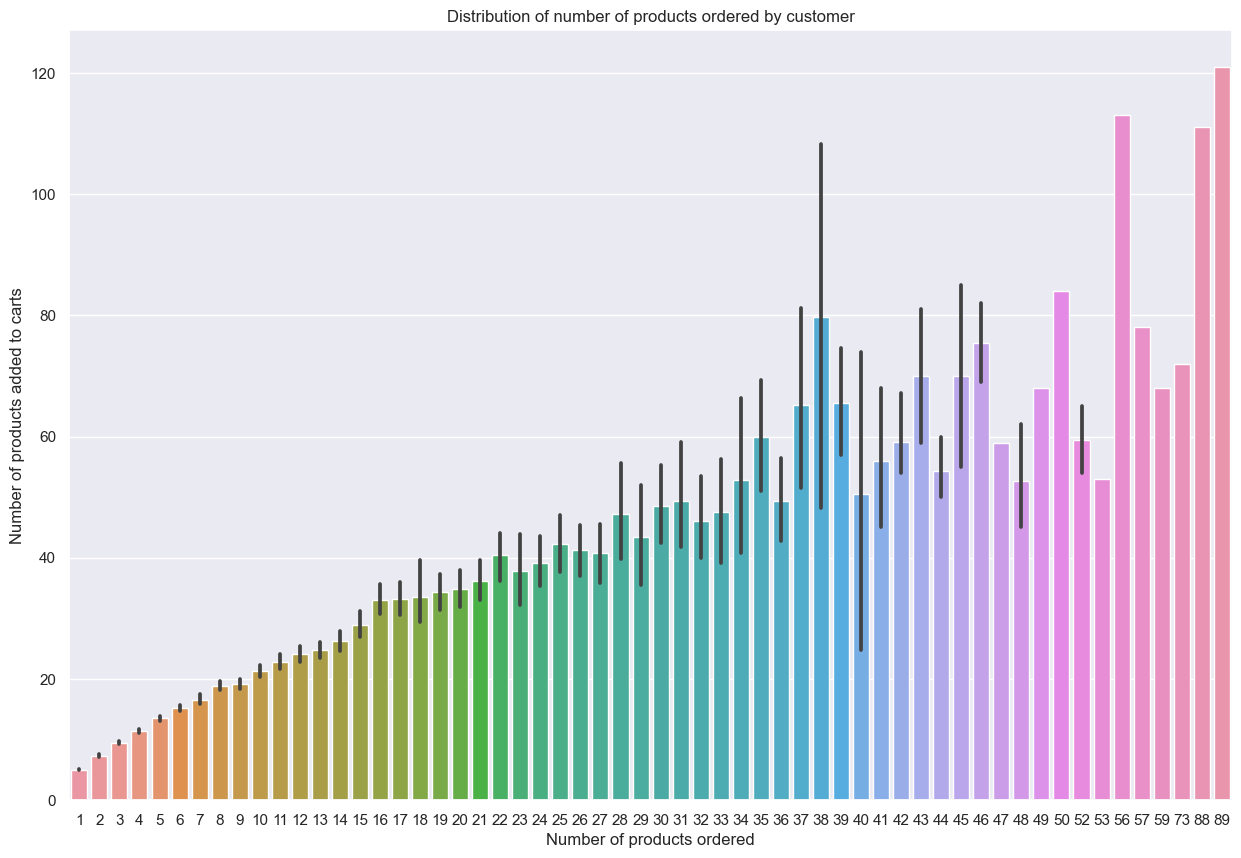

In [158]:
# Number of products ordered vs. number of products added to cart
plt.figure(figsize=(15, 10))
sns.barplot(x=grouped_train_orders['aid_orders'], y=grouped_train_carts['aid_carts'])
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products ordered')
plt.ylabel('Number of products added to carts')
plt.show()

Renaming with polar

In [ ]:
df1= train_p.clone()

In [ ]:
from_ = [0, 1, 2]
to_ = ['click', 'cart', 'order']

In [ ]:
df1= df1.with_column(
    pl.when(pl.col("type") == from_[0])
    .then(to_[0])
    .when(pl.col("type") == from_[1])
    .then(to_[1])
    .when(pl.col("type") == from_[2])
    .then(to_[2])
    .otherwise(pl.col("type")).alias("type")
)

df1['type'].unique()

type
str
"""order"""
"""cart"""
"""click"""


## 6. Cleaning?

Notebook Inspiration:

https://www.kaggle.com/code/edwardcrookenden/otto-getting-started-eda-baseline

https://www.kaggle.com/code/parthpankajtiwary/otto-eda-understanding-users-and-events

https://www.kaggle.com/code/mvvppp/otto-eda-to-getting-started